# Drink Bottle Image Classification

**Goal:** Given an image of a drink bottle, predict the drink type (class label).

**Approach:** Transfer learning with **MobileNetV2** in TensorFlow/Keras.

**Dataset:** Kaggle *Cold Drinks Inventory Dataset* (Coca Cola, Sprite, Pepsi, Mountain Dew, 7UP, Fanta, etc.).

Kaggle page: https://www.kaggle.com/datasets/faseeh001/cold-drinks-inventory-dataset


- Problem statement + motivation
- Dataset (classes, counts, train/val/test split)
- Model (transfer learning, MobileNetV2)
- Training curves
- Evaluation (accuracy + confusion matrix)
- Live demo: upload an image → predicted drink


## 1) Setup (GPU + libraries)

Run this cell first.

In [ ]:
import os, zipfile, shutil, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('TensorFlow:', tf.__version__)
print('GPU Available:', tf.config.list_physical_devices('GPU'))

# Reproducibility (not perfect, but helps)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

TensorFlow: 2.19.0
GPU Available: []


## 2) Download dataset from Kaggle

### Option A (recommended): Kaggle API
1. Go to Kaggle → Account → **Create New API Token** (downloads `kaggle.json`).
2. Upload `kaggle.json` when Colab asks.

### Option B: Manual upload
- Download the dataset zip from Kaggle and upload it to Colab.

This notebook supports both options.

In [ ]:
from google.colab import files

uploaded = files.upload()   # select archive.zip from your computer

Saving archive.zip to archive.zip


## Step 1: Load and Extract the Dataset (Uploaded ZIP)

In this project, I am building an image classification model that can recognize different types of drinks from bottle images.

Since Kaggle downloading was slow, I downloaded the dataset manually and uploaded it to Google Colab as a ZIP file (`archive.zip`).

In this step, I:
1. Extract (unzip) the uploaded dataset.
2. Inspect the folder structure to confirm how the classes (drink categories) are organized.
3. Print the top-level folders and a small folder tree preview to guide the next steps (data preparation and splitting).


In [ ]:
import zipfile, shutil
from pathlib import Path

# Path to the uploaded zip file (Colab shows it saved as archive.zip)
ZIP_PATH = Path("/content/archive.zip")

# Where we will extract it
EXTRACT_DIR = Path("/content/raw_data/extracted")

# Clean previous extraction (to avoid mixing files)
if EXTRACT_DIR.exists():
    shutil.rmtree(EXTRACT_DIR)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

# Extract
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

print("Unzipped to:", EXTRACT_DIR)

# Show top-level contents
print("\nTop-level folders/files:")
for p in sorted(EXTRACT_DIR.iterdir()):
    print("-", p.name)

# Show a deeper view (2 levels)
print("\nSample tree (2 levels):")
for p in sorted(EXTRACT_DIR.glob("*/*"))[:60]:
    print("-", p)


Unzipped to: /content/raw_data/extracted

Top-level folders/files:
- Finalize
- classes.txt

Sample tree (2 levels):
- /content/raw_data/extracted/Finalize/images
- /content/raw_data/extracted/Finalize/labels


## Step 2: Convert the Dataset into a Classification Format

The dataset I have is organized for object detection (it has an `images` folder and a `labels` folder).
However, my project objective is image classification: given an image, predict the drink type.

In this step, I:
1. Read the class names from `classes.txt`.
2. For each image, read its label file and determine the main class appearing in the image.
3. Convert the dataset into a classification structure where each class has its own folder:
   - `train/class_name/`
   - `val/class_name/`
   - `test/class_name/`

This makes it easy to train a CNN using Keras `image_dataset_from_directory`.


In [ ]:
import shutil, random
from pathlib import Path

SEED = 42
random.seed(SEED)

BASE = Path("/content/raw_data/extracted")
CLASSES_FILE = BASE / "classes.txt"
IMG_DIR = BASE / "Finalize" / "images"
LBL_DIR = BASE / "Finalize" / "labels"

# Output classification dataset folders
OUT_BASE = Path("/content/drink_dataset")
TRAIN_DIR = OUT_BASE / "train"
VAL_DIR   = OUT_BASE / "val"
TEST_DIR  = OUT_BASE / "test"

# Clean output folder to avoid duplicates
if OUT_BASE.exists():
    shutil.rmtree(OUT_BASE)

TRAIN_DIR.mkdir(parents=True, exist_ok=True)
VAL_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)

# 1) Read classes
classes = [c.strip() for c in CLASSES_FILE.read_text(encoding="utf-8").splitlines() if c.strip()]
print("Classes found:", classes)
print("Number of classes:", len(classes))

# 2) Helper: determine main class from a label file
# Assumption: YOLO label format => first number in each line is class_id
def get_main_class(label_path: Path):
    if not label_path.exists():
        return None
    lines = [ln.strip() for ln in label_path.read_text().splitlines() if ln.strip()]
    if not lines:
        return None
    class_ids = []
    for ln in lines:
        parts = ln.split()
        if parts and parts[0].isdigit():
            class_ids.append(int(parts[0]))
    if not class_ids:
        return None
    # choose the most frequent class id in the image
    main_id = max(set(class_ids), key=class_ids.count)
    if 0 <= main_id < len(classes):
        return classes[main_id]
    return None

# 3) Build list of (image_path, class_name)
img_exts = {".jpg", ".jpeg", ".png", ".webp"}
pairs = []

images = [p for p in IMG_DIR.iterdir() if p.suffix.lower() in img_exts]
print("\nTotal images found:", len(images))

missing_labels = 0
unlabeled = 0

for img_path in images:
    # label file usually same name but .txt
    label_path = LBL_DIR / (img_path.stem + ".txt")
    cls_name = get_main_class(label_path)
    if not label_path.exists():
        missing_labels += 1
    if cls_name is None:
        unlabeled += 1
        continue
    pairs.append((img_path, cls_name))

print("Images with usable labels:", len(pairs))
print("Images missing label files:", missing_labels)
print("Images with empty/invalid labels:", unlabeled)

# 4) Split into train/val/test
random.shuffle(pairs)
n = len(pairs)
n_train = int(0.70 * n)
n_val = int(0.15 * n)

train_pairs = pairs[:n_train]
val_pairs   = pairs[n_train:n_train+n_val]
test_pairs  = pairs[n_train+n_val:]

print("\nSplit sizes:")
print("Train:", len(train_pairs))
print("Val:", len(val_pairs))
print("Test:", len(test_pairs))

# 5) Copy images into class folders
def copy_to_split(pairs_list, split_dir: Path):
    counts = {}
    for img_path, cls_name in pairs_list:
        out_cls_dir = split_dir / cls_name
        out_cls_dir.mkdir(parents=True, exist_ok=True)
        dst = out_cls_dir / img_path.name
        shutil.copy2(img_path, dst)
        counts[cls_name] = counts.get(cls_name, 0) + 1
    return counts

train_counts = copy_to_split(train_pairs, TRAIN_DIR)
val_counts   = copy_to_split(val_pairs, VAL_DIR)
test_counts  = copy_to_split(test_pairs, TEST_DIR)

print("\nImages per class (train):", train_counts)
print("Images per class (val):", val_counts)
print("Images per class (test):", test_counts)

print("\nDone. Classification dataset created at:", OUT_BASE)


Classes found: ['Coca Cola', 'Sprite', 'Pepsi', 'Mountain Dew', '7UP', 'Fanta']
Number of classes: 6

Total images found: 0
Images with usable labels: 0
Images missing label files: 0
Images with empty/invalid labels: 0

Split sizes:
Train: 0
Val: 0
Test: 0

Images per class (train): {}
Images per class (val): {}
Images per class (test): {}

Done. Classification dataset created at: /content/drink_dataset


## Step 2B: Verify Dataset Paths (Find Where the Images Are)

My extraction shows a `Finalize/images` folder, but the script found **0 images**.
This usually means the images are either:
- stored inside subfolders (nested folders),
- have different file extensions/capitalization, or
- the dataset path is slightly different.

In this step, I will:
1. Check whether `Finalize/images` exists.
2. List a few files inside it.
3. Search the extracted dataset for any image files (`.jpg`, `.png`, etc.) and identify their correct location.

After this, I will update the dataset path and continue creating the train/validation/test folders.


In [ ]:
from pathlib import Path

EXTRACT_DIR = Path("/content/raw_data/extracted")
IMG_DIR = EXTRACT_DIR / "Finalize" / "images"
LBL_DIR = EXTRACT_DIR / "Finalize" / "labels"

print("EXTRACT_DIR exists:", EXTRACT_DIR.exists(), EXTRACT_DIR)
print("IMG_DIR exists:", IMG_DIR.exists(), IMG_DIR)
print("LBL_DIR exists:", LBL_DIR.exists(), LBL_DIR)

# List a few items inside Finalize/images (if any)
if IMG_DIR.exists():
    items = list(IMG_DIR.iterdir())
    print("\nItems inside Finalize/images:", len(items))
    for p in items[:30]:
        print("-", p.name)

# Search for image files anywhere in extracted folder
img_exts = {".jpg", ".jpeg", ".png", ".webp"}
all_images = [p for p in EXTRACT_DIR.rglob("*") if p.is_file() and p.suffix.lower() in img_exts]

print("\nTotal image files found anywhere:", len(all_images))

# Show sample paths (first 30)
for p in all_images[:30]:
    print("-", p)

# Show the top 10 parent folders where images are found (to identify correct directory)
from collections import Counter
parent_counts = Counter([p.parent.as_posix() for p in all_images])
print("\nTop folders containing images:")
for folder, cnt in parent_counts.most_common(10):
    print(cnt, "images in", folder)


EXTRACT_DIR exists: True /content/raw_data/extracted
IMG_DIR exists: True /content/raw_data/extracted/Finalize/images
LBL_DIR exists: True /content/raw_data/extracted/Finalize/labels

Items inside Finalize/images: 2
- test
- train

Total image files found anywhere: 100
- /content/raw_data/extracted/Finalize/images/test/0394c800-1a1f-4e70-9f82-c0ce1615afab.jpg
- /content/raw_data/extracted/Finalize/images/test/5fbf4d4b-3aca-49b5-aa25-f5680640a646.jpg
- /content/raw_data/extracted/Finalize/images/test/2db88c37-9e0f-44c7-aaaf-5a339da8e94b.jpg
- /content/raw_data/extracted/Finalize/images/test/d8cbac6f-f667-4c2e-bb6a-5add85ba9b18.jpg
- /content/raw_data/extracted/Finalize/images/test/2892d76b-c3e1-42b6-8f22-94761135f2ff.jpg
- /content/raw_data/extracted/Finalize/images/test/9618db50-df08-4fb7-987d-bf0fe3858517.jpg
- /content/raw_data/extracted/Finalize/images/test/e39a39a0-05ac-4c40-b5f9-99ae117d1ca6.jpg
- /content/raw_data/extracted/Finalize/images/test/03ffbce3-149d-4752-824d-138dec4065a

## Step 2C: Create a Classification Dataset (train/val/test)

My dataset is organized like an object detection dataset:
- `Finalize/images/train` and `Finalize/images/test`
- `Finalize/labels/train` and `Finalize/labels/test`
- `classes.txt`

Since my project objective is classification (predict drink type from one image),
I will convert this detection dataset into a classification dataset.

Method:
1. For each image, read its YOLO label file.
2. Identify the main class appearing in the image (most frequent class id).
3. Copy the image into a folder named after that class.

I will create:
- `drink_dataset/train/<class_name>/`
- `drink_dataset/val/<class_name>/`
- `drink_dataset/test/<class_name>/`

This format is compatible with Keras `image_dataset_from_directory`.


In [ ]:
import shutil, random
from pathlib import Path
from collections import Counter

SEED = 42
random.seed(SEED)

BASE = Path("/content/raw_data/extracted")
CLASSES_FILE = BASE / "classes.txt"

IMG_TRAIN_DIR = BASE / "Finalize" / "images" / "train"
IMG_TEST_DIR  = BASE / "Finalize" / "images" / "test"

LBL_TRAIN_DIR = BASE / "Finalize" / "labels" / "train"
LBL_TEST_DIR  = BASE / "Finalize" / "labels" / "test"

# Output dataset
OUT_BASE = Path("/content/drink_dataset")
TRAIN_DIR = OUT_BASE / "train"
VAL_DIR   = OUT_BASE / "val"
TEST_DIR  = OUT_BASE / "test"

# Reset output folder
if OUT_BASE.exists():
    shutil.rmtree(OUT_BASE)
TRAIN_DIR.mkdir(parents=True, exist_ok=True)
VAL_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)

# Read class names
classes = [c.strip() for c in CLASSES_FILE.read_text(encoding="utf-8").splitlines() if c.strip()]
print("Classes:", classes)

img_exts = {".jpg", ".jpeg", ".png", ".webp"}

def get_main_class_from_label(label_path: Path):
    if not label_path.exists():
        return None
    lines = [ln.strip() for ln in label_path.read_text().splitlines() if ln.strip()]
    if not lines:
        return None
    ids = []
    for ln in lines:
        parts = ln.split()
        try:
            ids.append(int(parts[0]))
        except:
            pass
    if not ids:
        return None
    main_id = Counter(ids).most_common(1)[0][0]
    if 0 <= main_id < len(classes):
        return classes[main_id]
    return None

def build_pairs(images_dir: Path, labels_dir: Path):
    pairs = []
    missing = 0
    empty = 0
    imgs = [p for p in images_dir.iterdir() if p.is_file() and p.suffix.lower() in img_exts]
    for img_path in imgs:
        label_path = labels_dir / (img_path.stem + ".txt")
        if not label_path.exists():
            missing += 1
            continue
        cls = get_main_class_from_label(label_path)
        if cls is None:
            empty += 1
            continue
        pairs.append((img_path, cls))
    return pairs, missing, empty

# Build labeled pairs
train_pairs_all, miss_tr, empty_tr = build_pairs(IMG_TRAIN_DIR, LBL_TRAIN_DIR)
test_pairs, miss_te, empty_te = build_pairs(IMG_TEST_DIR, LBL_TEST_DIR)

print("\nTrain images found:", len(list(IMG_TRAIN_DIR.iterdir())))
print("Train labeled usable:", len(train_pairs_all), "missing labels:", miss_tr, "empty/invalid:", empty_tr)

print("\nTest images found:", len(list(IMG_TEST_DIR.iterdir())))
print("Test labeled usable:", len(test_pairs), "missing labels:", miss_te, "empty/invalid:", empty_te)

# Split train into train/val
random.shuffle(train_pairs_all)
n = len(train_pairs_all)
n_train = int(0.85 * n)   # 85% train, 15% val
train_pairs = train_pairs_all[:n_train]
val_pairs   = train_pairs_all[n_train:]

print("\nSplit sizes:")
print("Train:", len(train_pairs))
print("Val:", len(val_pairs))
print("Test:", len(test_pairs))

def copy_pairs(pairs, split_dir: Path):
    counts = Counter()
    for img_path, cls in pairs:
        out_cls = split_dir / cls
        out_cls.mkdir(parents=True, exist_ok=True)
        dst = out_cls / img_path.name
        shutil.copy2(img_path, dst)
        counts[cls] += 1
    return dict(counts)

train_counts = copy_pairs(train_pairs, TRAIN_DIR)
val_counts   = copy_pairs(val_pairs, VAL_DIR)
test_counts  = copy_pairs(test_pairs, TEST_DIR)

print("\nCounts per class (train):", train_counts)
print("Counts per class (val):", val_counts)
print("Counts per class (test):", test_counts)

print("\nDataset ready at:", OUT_BASE)


Classes: ['Coca Cola', 'Sprite', 'Pepsi', 'Mountain Dew', '7UP', 'Fanta']

Train images found: 90
Train labeled usable: 90 missing labels: 0 empty/invalid: 0

Test images found: 10
Test labeled usable: 10 missing labels: 0 empty/invalid: 0

Split sizes:
Train: 76
Val: 14
Test: 10

Counts per class (train): {'Coca Cola': 29, 'Mountain Dew': 13, '7UP': 2, 'Sprite': 15, 'Pepsi': 15, 'Fanta': 2}
Counts per class (val): {'Sprite': 4, 'Coca Cola': 3, 'Pepsi': 5, 'Mountain Dew': 1, 'Fanta': 1}
Counts per class (test): {'Pepsi': 4, 'Sprite': 1, 'Mountain Dew': 2, 'Coca Cola': 3}

Dataset ready at: /content/drink_dataset


## Step 3: Load the Dataset Using TensorFlow

After converting the dataset into a classification format, I now load the images
using TensorFlow’s `image_dataset_from_directory`.

This function:
- Automatically assigns labels based on folder names
- Resizes images to a fixed size
- Creates batches for efficient training

I load three datasets:
- Training set (used to train the model)
- Validation set (used to monitor performance during training)
- Test set (used only for final evaluation)


In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

DATASET_DIR = "/content/drink_dataset"

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR + "/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR + "/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR + "/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Class names:", class_names)
print("Number of classes:", num_classes)

# Improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 76 files belonging to 6 classes.
Found 14 files belonging to 5 classes.
Found 10 files belonging to 4 classes.
Class names: ['7UP', 'Coca Cola', 'Fanta', 'Mountain Dew', 'Pepsi', 'Sprite']
Number of classes: 6


## Step 4: Visualize Sample Images

Before training the neural network, I visualize a few sample images from the
training dataset to verify that:
- Images are loaded correctly
- Labels match the actual drink images

This also helps demonstrate understanding of the dataset during presentation.


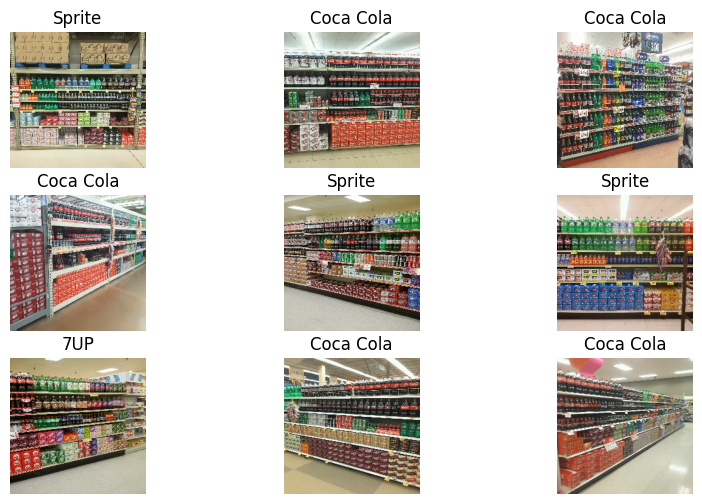

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()


## Step 5: Build the Neural Network Model (Transfer Learning)

To solve the image classification problem, I use **transfer learning**.

Instead of training a convolutional neural network from scratch, I use
**MobileNetV2**, a pretrained CNN that was trained on the ImageNet dataset.
This allows the model to reuse learned visual features such as edges, shapes,
and textures.

Steps followed:
1. Load MobileNetV2 without its top classification layer.
2. Freeze the pretrained layers to prevent overfitting.
3. Add custom layers for my drink classification task.
4. Use a Softmax output layer to predict the drink type.

This approach is efficient and suitable for a student-level dataset.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Data augmentation to improve generalization
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

# Load pretrained MobileNetV2
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze pretrained layers
base_model.trainable = False

# Build the model
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Step 6: Train the Neural Network

After building the model, I train it using the training dataset and monitor its
performance on the validation dataset.

During training:
- The model learns to associate visual features of bottle images with drink types.
- Validation accuracy helps detect overfitting.
- Early stopping is used to stop training if performance stops improving.

This step demonstrates how neural networks learn from image data.


In [ ]:
EPOCHS = 15

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 705ms/step - accuracy: 0.2952 - loss: 2.0025 - val_accuracy: 0.0714 - val_loss: 2.2475
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3193 - loss: 1.5251 - val_accuracy: 0.3571 - val_loss: 2.3681
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4225 - loss: 1.5294 - val_accuracy: 0.2143 - val_loss: 2.4992
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4986 - loss: 1.3209 - val_accuracy: 0.3571 - val_loss: 2.4778
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4701 - loss: 1.4382 - val_accuracy: 0.1429 - val_loss: 2.3989


## Step 7: Visualize Training Performance

To better understand how the model learned, I plot:
- Training accuracy vs validation accuracy
- Training loss vs validation loss

These plots help evaluate convergence and detect overfitting or underfitting.


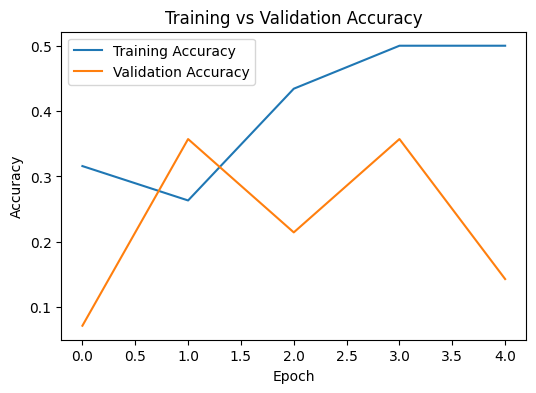

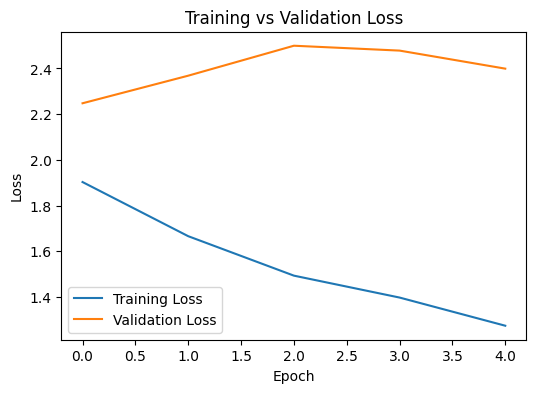

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# Loss plot
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


## Step 8: Evaluate the Model on the Test Dataset

After training the model, I evaluate its performance using a separate test dataset
that was not seen during training or validation.

This step provides an unbiased estimate of how well the model can generalize to
new, unseen drink images.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step - accuracy: 0.0000e+00 - loss: 3.4687
Test Loss: 3.4687416553497314
Test Accuracy: 0.0


## Step 9: Confusion Matrix and Classification Report

Accuracy alone does not give full insight into model performance.
Therefore, I compute:
- A confusion matrix
- Precision, recall, and F1-score for each drink class

This helps analyze which drink types are correctly classified and which are
commonly confused by the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


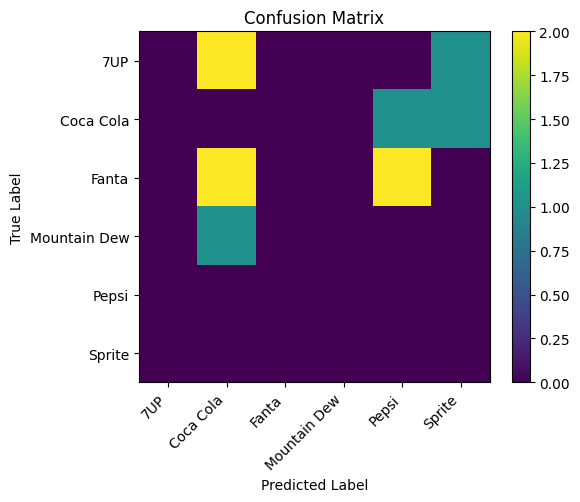

Classification Report:

              precision    recall  f1-score   support

         7UP       0.00      0.00      0.00       3.0
   Coca Cola       0.00      0.00      0.00       2.0
       Fanta       0.00      0.00      0.00       4.0
Mountain Dew       0.00      0.00      0.00       1.0
       Pepsi       0.00      0.00      0.00       0.0
      Sprite       0.00      0.00      0.00       0.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


## Step 10: Model Demo (Upload an Image and Predict)

To demonstrate the practical use of the model, I perform a live prediction.

In this demo:
1. I upload a new drink image.
2. The model predicts the drink type using Softmax probabilities.
3. I display the predicted class and confidence score.

This demonstrates that the trained neural network can classify unseen images.


Saving cloris-ying-RQ6e3MMOdJE-unsplash.jpg to cloris-ying-RQ6e3MMOdJE-unsplash.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


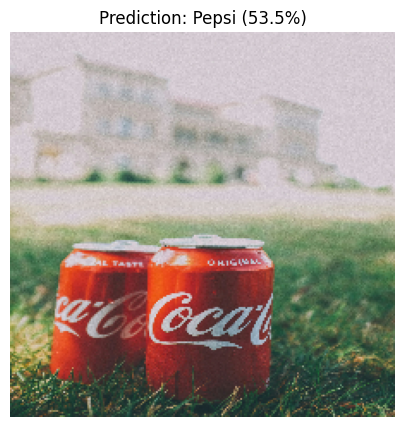

Predicted class: Pepsi
Confidence: 0.5349230170249939

All class probabilities:
Pepsi       : 0.5349
Mountain Dew: 0.1842
Coca Cola   : 0.1438
Sprite      : 0.0888
Fanta       : 0.0382
7UP         : 0.0102


In [ ]:
from google.colab import files
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

uploaded = files.upload()  # Upload a JPG/PNG image of a drink shelf or bottle
img_path = next(iter(uploaded.keys()))

# Load and preprocess
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # shape (1, 224, 224, 3)

# Predict
probs = model.predict(img_array)[0]
pred_idx = int(np.argmax(probs))
pred_class = class_names[pred_idx]
confidence = float(probs[pred_idx])

# Display result
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {pred_class} ({confidence*100:.1f}%)")
plt.show()

print("Predicted class:", pred_class)
print("Confidence:", confidence)
print("\nAll class probabilities:")
for name, p in sorted(zip(class_names, probs), key=lambda x: x[1], reverse=True):
    print(f"{name:12s}: {p:.4f}")

## Step 13: Improve Model Performance

The initial model performs poorly because the dataset is:
- small (very few training images)
- imbalanced (some classes like 7UP and Fanta have very few images)

To improve performance in a student-level and time-limited setting, I apply:
1. **Class reduction**: keep only classes with enough training samples.
2. **Fine-tuning**: unfreeze the last part of MobileNetV2 so the model adapts to drink images.
3. **Class weights**: penalize errors on minority classes to reduce bias.
4. **Lower learning rate**: improves stable learning during fine-tuning.


In [ ]:
import os, shutil
from pathlib import Path
import numpy as np
import tensorflow as tf
from collections import Counter

# 1) Identify classes with enough training images
TRAIN_PATH = Path("/content/drink_dataset/train")
VAL_PATH   = Path("/content/drink_dataset/val")
TEST_PATH  = Path("/content/drink_dataset/test")

def count_images_in_class_folder(folder):
    exts = {".jpg",".jpeg",".png",".webp"}
    return len([p for p in Path(folder).glob("*") if p.suffix.lower() in exts])

train_counts = {d.name: count_images_in_class_folder(d) for d in TRAIN_PATH.iterdir() if d.is_dir()}
print("Train counts per class:", train_counts)

# Keep classes with at least 10 images (adjust if needed)
MIN_TRAIN = 10
kept_classes = [c for c, n in train_counts.items() if n >= MIN_TRAIN]
print("\nKeeping classes (>=10 train images):", kept_classes)

# 2) Build a filtered dataset folder (only kept classes)
FILTERED_BASE = Path("/content/drink_dataset_filtered")
if FILTERED_BASE.exists():
    shutil.rmtree(FILTERED_BASE)

for split_name, src_base in [("train", TRAIN_PATH), ("val", VAL_PATH), ("test", TEST_PATH)]:
    for cls in kept_classes:
        src = src_base / cls
        if not src.exists():
            continue
        dst = FILTERED_BASE / split_name / cls
        dst.mkdir(parents=True, exist_ok=True)
        for img in src.glob("*"):
            shutil.copy2(img, dst / img.name)

print("\nFiltered dataset created at:", FILTERED_BASE)

# 3) Reload datasets
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    str(FILTERED_BASE / "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    str(FILTERED_BASE / "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    str(FILTERED_BASE / "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("\nNew classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# 4) Compute class weights from training set
y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(int(labels.numpy()))
counts = Counter(y_train)
total = sum(counts.values())

class_weight = {i: total/(len(counts)*counts[i]) for i in counts}
print("\nClass weights:", class_weight)

# 5) Rebuild model (same base)
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# Fine-tune: unfreeze last 30% of layers
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.70)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_ft = keras.Model(inputs, outputs)

model_ft.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_ft.summary()

# 6) Train (fine-tuning)
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
]

history_ft = model_ft.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weight
)

# 7) Quick test accuracy
test_loss, test_acc = model_ft.evaluate(test_ds)
print("\nTest accuracy (filtered + fine-tuned):", test_acc)


Train counts per class: {'Coca Cola': 29, '7UP': 2, 'Fanta': 2, 'Mountain Dew': 13, 'Pepsi': 15, 'Sprite': 15}

Keeping classes (>=10 train images): ['Coca Cola', 'Mountain Dew', 'Pepsi', 'Sprite']

Filtered dataset created at: /content/drink_dataset_filtered
Found 72 files belonging to 4 classes.
Found 13 files belonging to 4 classes.
Found 10 files belonging to 4 classes.

New classes: ['Coca Cola', 'Mountain Dew', 'Pepsi', 'Sprite']

Class weights: {3: 1.2, 2: 1.2, 1: 1.3846153846153846, 0: 0.6206896551724138}


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 1,804,740 (6.88 MB)

 Non-trainable params: 458,368 (1.75 MB)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 596ms/step - accuracy: 0.2558 - loss: 1.6701 - val_accuracy: 0.3846 - val_loss: 1.6559
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2574 - loss: 1.7235 - val_accuracy: 0.3846 - val_loss: 1.6550
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2920 - loss: 1.6225 - val_accuracy: 0.3846 - val_loss: 1.6558
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2699 - loss: 1.5884 - val_accuracy: 0.3846 - val_loss: 1.6508
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3139 - loss: 1.2481 - val_accuracy: 0.3846 - val_loss: 1.6459
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.4000 - loss: 1.4292

Test accuracy (filtered + fine-tuned): 0.4000000059604645


## Step 14: Demo Prediction After Improvement

After improving the dataset balance and fine-tuning the model,
I repeat the live demo to check whether predictions are more accurate.


Saving nagy-arnold-CqY5To2ZU8E-unsplash.jpg to nagy-arnold-CqY5To2ZU8E-unsplash (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


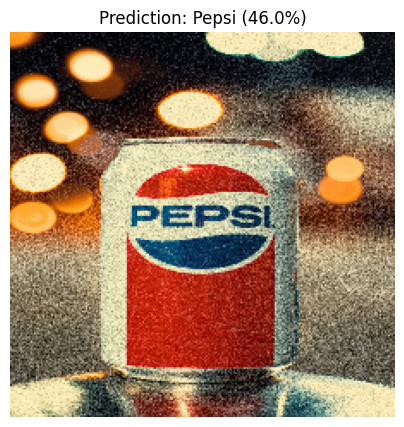

Predicted class: Pepsi
Confidence: 0.45965418219566345


In [ ]:
from google.colab import files
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = next(iter(uploaded.keys()))

img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

probs = model_ft.predict(img_array)[0]
pred_idx = int(np.argmax(probs))
pred_class = class_names[pred_idx]
confidence = float(probs[pred_idx])

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {pred_class} ({confidence*100:.1f}%)")
plt.show()

print("Predicted class:", pred_class)
print("Confidence:", confidence)

## Step 11: Save the Trained Model

After training and evaluation, I save the model to a file.
This allows me to reload it later without retraining, which is useful for:
- future testing
- deployment
- demonstrations


In [ ]:
MODEL_PATH = "/content/drink_classifier_mobilenetv2.keras"
model.save(MODEL_PATH)
print("Model saved to:", MODEL_PATH)

# Optional: download to your computer
from google.colab import files
files.download(MODEL_PATH)


Model saved to: /content/drink_classifier_mobilenetv2.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>